# Notebook on Added Value
This notebook will be used to show an example on how added value is calculated.

In [1]:
import lib
from dask.distributed import Client,Scheduler,LocalCluster
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 125.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39135,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 125.21 GiB
Comm: tcp://127.0.0.1:41231,Total threads: 1
Dashboard: /proxy/36087/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:36757,


Open the global driving model (gcm) data, the regional climate model (rcm) data, and reference data (observations).

In [3]:
ds_gcm = lib.open_dataset("/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r4i1p1f1/day/tasmax/gn/v20210607/tasmax_day_ACCESS-CM2_historical_r4i1p1f1_gn_*-*.nc")
ds_rcm = lib.open_dataset("/g/data/tp28/ACS_DRS_v0.3/CORDEX-CMIP6/output/AUS-17i/BOM/CSIRO-BOM-ACCESS-CM2/historical/r4i1p1f1/BOM-BARPA-R/v1/day/tasmax/*.nc")
ds_obs = lib.open_dataset("/g/data/xv83/agcd-csiro/tmax/daily/tmax_AGCD-CSIRO_r005_*-*_daily.nc")

Let's have a look at the files that were opened.

The gcm data looks like:

In [4]:
ds_gcm

<xarray.Dataset>
Dimensions:    (time: 60265, bnds: 2, lat: 144, lon: 192)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01T12:00:00 ... 2014-12-31T12:00:00
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(18262, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
    tasmax     (time, lat, lon) float32 dask.array<chunksize=(18262, 144, 192), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  54786.0
    creation_date:          2021-06-07T09:31:22Z
    ...                     ...
    variable_id:            tasmax
    variant_label:          r4i1p1f1
    version:                v20210607
    license:                CMIP6 model data produced by CSIRO is licensed un...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/1e162cb6-32e9-4d99-9597-c856cad91f27

The rcm data looks like:

In [5]:
ds_rcm

<xarray.Dataset>
Dimensions:    (time: 3653, lat: 427, lon: 767, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1989-12-31
  * lat        (lat) float64 -53.11 -52.96 -52.8 -52.65 ... 12.4 12.55 12.7
  * lon        (lon) float64 88.81 88.96 89.12 89.27 ... 206.7 206.8 207.0 207.2
    height     float64 ...
  * bnds       (bnds) float64 0.0 1.0
Data variables:
    tasmax     (time, lat, lon) float32 dask.array<chunksize=(366, 427, 767), meta=np.ndarray>
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(366, 2), meta=np.ndarray>
Attributes: (12/59)
    axiom_version:                  0.1.0
    axiom_schemas_version:          0.1.0
    axiom_schema:                   cordex-1D.json
    Conventions:                    CF-1.7, ACDD-1.3
    title:                          Bureau of Meteorology Atmospheric high-re...
    source:                         Data from Met Office Unified Model
    ...                             ...
    tracking_id:                    8f787026-a85e-4266-a4e6-94d4daff3d5f
    date_created:                   2022-05-26T13:48:18Z
    date_modified:                  2022-05-26T13:48:18Z
    date_metadata_modified:         2022-05-26T13:48:18Z
    license:                        ??? to be advised by legal. CC BY-SA 4.0 ...
    history:                        Thu May 26 23:47:55 2022: /g/data/hh5/pub...

And finally the observations look like:

In [6]:
ds_obs

<xarray.Dataset>
Dimensions:    (lon: 886, bnds: 2, lat: 691, time: 41002)
Coordinates:
  * lon        (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
  * lat        (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * time       (time) datetime64[ns] 1910-01-01T09:00:00 ... 2022-04-04T09:00:00
Dimensions without coordinates: bnds
Data variables:
    lon_bnds   (lon, bnds) float32 dask.array<chunksize=(886, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float32 dask.array<chunksize=(691, 2), meta=np.ndarray>
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(365, 2), meta=np.ndarray>
    tmax       (time, lat, lon) float32 dask.array<chunksize=(365, 691, 886), meta=np.ndarray>
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    history:                       Tue Sep 03 15:18:22 2019: cdo -O -z zip_4 ...
    institution:                   Australian Bureau of Meteorology, GPO Box ...
    Conventions:                   CF-1.6
    geospatial_lat_min:            -44.525
    geospatial_lat_max:            -9.975
    ...                            ...
    url:                           http://www.bom.gov.au/climate/
    licence:                       Copyright for any data supplied by the Bur...
    id:                            Australian Gridded Climate Data (AGCD)
    summary:                       The daily maximum temperature station data...
    naming_authority:              au.gov.bom
    CDO:                           Climate Data Operators version 1.7.0 (http...

## Prepare data for added value analysis
This involves cutting all datasets to the same extend in time, latitude and longitude extension, which for now is the time period between 1980 and 1989,

In [7]:
da_gcm = ds_gcm["tasmax"]
da_rcm = ds_rcm["tasmax"]
da_obs = ds_obs["tmax"] + 273.15 # Convert Celsius to Kelvin

In [8]:
da_gcm = da_gcm.sel(time=slice("1980-01-01","1989-12-31"))
da_rcm = da_rcm.sel(time=slice("1980-01-01","1989-12-31"))
da_obs = da_obs.sel(time=slice("1980-01-01","1989-12-31"))

latitude between -44.5 to -9.8 and longitude between 111.5625 to 156.5625. For the gcm and obs data we keep a bit more to allow for the regridding to work properly.

In [9]:
da_gcm = da_gcm.sel(lat=slice(-45.625,-9.375), lon=slice(111.5625,156.5625))
da_rcm = da_rcm.sel(lat=slice(-44.5,-9.8), lon=slice(111.5625,156.5625))
da_obs = da_obs.sel(lat=slice(-45.625,-9.375), lon=slice(111.5625,156.5625))

## Quantile calculations
Now that we have the data in the correct shape lets calculate the quantiles. In this example we have chosen the 90th percentile. Because xarray cannot calculate quantiles over chunked dimensions we also have to re-chunk the data.

In [10]:
da_gcm = da_gcm.chunk({"time":None, "lat":"auto"})
da_rcm = da_rcm.chunk({"time":None, "lat":"auto"})
da_obs = da_obs.chunk({"time":None, "lat":"auto"})

In [11]:
q = 0.9
X_gcm = da_gcm.quantile(q,"time", skipna=True).load()
X_rcm = da_rcm.quantile(q,"time", skipna=True).load()
X_obs = da_obs.quantile(q,"time", skipna=True).load()

## Regridding and masking
Before we can calculate added value we have to bring all data to the same grid. For now we will do this by bilinear interpolation of the global model data to the resolution of the regional model and conservative interpolation of the observation data to the regional model resolution.

In [12]:
X_gcm = lib.regrid(X_gcm, X_rcm, method="bilinear")
X_gcm = X_gcm.rename({"latitude":"lat", "longitude":"lon"})

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xesmf/frontend.py:594: UserWarning: Using dimensions ('lat', 'lon') from data variable tasmax as the horizontal dimensions for the regridding.
  warnings.warn(


In [13]:
X_obs = lib.regrid(X_obs, X_rcm, method="conservative_normed")
X_obs = X_obs.rename({"latitude":"lat", "longitude":"lon"})

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xesmf/frontend.py:594: UserWarning: Using dimensions ('lat', 'lon') from data variable tmax as the horizontal dimensions for the regridding.
  warnings.warn(


Round the coordinates to 4 digits before masking otherwise the coordinates are picked up as being different and xarray drops many grid-points.

In [14]:
X_gcm["lat"] = np.round(X_gcm["lat"],4)
X_gcm["lon"] = np.round(X_gcm["lon"],4)

X_rcm["lat"] = np.round(X_rcm["lat"],4)
X_rcm["lon"] = np.round(X_rcm["lon"],4)

We also have to mask the ocean. We do this after interpolating to GCM to the RCM grid to avoid a patchy coastline. This will favour the RCM along the coastline because the GCM "land" values will be a mix of ocean and land points.

In [15]:
#< Load the land sea mask from BARPA ancilary
lsmask_rcm = xr.open_dataset("/g/data/tp28/dev/barpa/ancils/barpa-r/land_sea_mask/cci/qrparm.mask.nc")["land_area_fraction"]
lsmask_rcm = lsmask_rcm.rename({"latitude":"lat", "longitude":"lon"})
lsmask_rcm = lsmask_rcm.sel(lat=slice(-44.5,-9.8), lon=slice(111.5625,156.5625))

#< Round coordinates to 4 digits
lsmask_rcm["lat"] = np.round(lsmask_rcm["lat"],4)
lsmask_rcm["lon"] = np.round(lsmask_rcm["lon"],4)

#< Mask 
X_rcm = X_rcm.where(lsmask_rcm>0)
X_gcm = X_gcm.where(lsmask_rcm>0)
X_obs = X_obs.where(lsmask_rcm>0)

Let's plot those three quantiles we have just calculate on a map

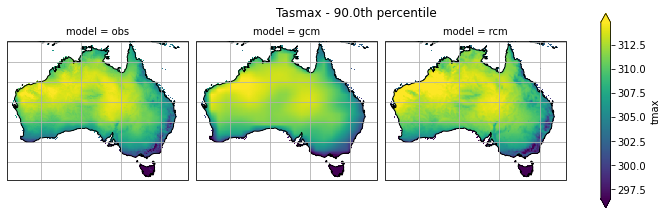

In [16]:
ds_plot = xr.concat([X_obs, X_gcm, X_rcm], dim=pd.Index(["obs","gcm","rcm"], name="model"))
p = ds_plot.plot.pcolormesh(col="model", robust=True, transform=ccrs.PlateCarree(), subplot_kws={"projection": ccrs.PlateCarree()})
plt.suptitle(f"Tasmax - {q*100}th percentile")
for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines()

## Added value

Now we can calculate the added value, measured as reduction in squared error, between the global and regional model data compared to observations. 

In [17]:
av = np.sqrt((X_gcm-X_obs)**2) - np.sqrt((X_rcm-X_obs)**2)

Let's plot the added value on a map

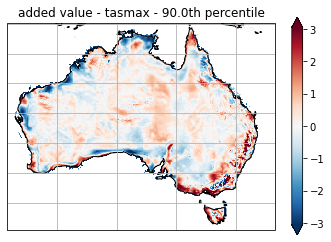

In [18]:
p = av.plot.pcolormesh(robust=True, transform=ccrs.PlateCarree(), subplot_kws={"projection": ccrs.PlateCarree()})
ax = p.axes
ax.set_title(f"added value - tasmax - {q*100}th percentile")
ax.coastlines()
ax.gridlines()